# Demo 1: Basics of Symlens (and Julia)

First make sure you follow the installation instruction to install Symlens.jl. If it works, the following line should not give any error message

In [1]:
using Symlens

To define a symbolic quantity, use `@syms`

In [2]:
# this defines a symbolic number
@syms l
# this defines two symbolic functions each with one parameter
@syms Claa(l) ClEE(l)

(Claa, ClEE)

In [3]:
# symbolic quantities can be used to build expressions
Claa(l)*ClEE(l)

ClEE(l)*Claa(l)

The core of `Symlens.jl` is a factorization engine that works on quadratic combinations of wigner 3j symbols summed over two out of three $\ell$'s. As an example, the B-mode power spectrum caused by a rotation field can be expressed as
$$ C_l^{BB} = \sum_{l_1 l_2} \begin{pmatrix} l & l_1 & l_2 \\ 2 & -2 & 0\end{pmatrix}^2 \frac{(2l_1+1)(2l_2+1)}{2\pi}\left(1+(-1)^{l_1+l_2+l}\right) C_{l_2}^{\alpha\alpha}C_{l_1}^{EE} $$
This expression contains a wigner 3j symbol squared and a summation of $l_1$ and $l_2$, which satisfies our condition so `Symlens.jl` is able to factorize this expression and build a fast calculator for it. This type of expression is seen over many places in lensing normalization calculation.
To allow for automatic factorization, `Symlens.jl` provides a few built-in symbolic quantities that have special meanings, such as $\ell$, $\ell_1$, $\ell_2$, `w3j`, `wigd`, and ℙ. In particular, $\ell_1$ and $\ell_2$ are assumed to be two of the three upper indices of wigner 3j symbol to be summed over while $\ell$ is the remaining free variable. `w3j` represents the wigner 3j symbol, `wigd` represents wigner (small) d matrix, and ℙ denotes a parity operator defined as $ℙ=(-1)^{\ell+\ell_1+\ell_2}$. Hence, in `Symlens.jl`'s notation, the above equation can be expressed as (ignore the summation for now)

In [4]:
expr = w3j(ℓ,ℓ₁,ℓ₂,2,-2,0)^2 * (2ℓ₁+1)*(2ℓ₂+1)/2π * (1+ℙ) * Claa(ℓ₂)*ClEE(ℓ₁);

Cheatsheet on how to type these unicode characters in julia

- ℓ: `\ell TAB`
- ℓ₁: `\ell TAB \_1 TAB`
- π: `\pi TAB`
- ℙ: `\bbP TAB`
- general rule: try latex expression followed by TAB, it usually work
- complete table: https://docs.julialang.org/en/v1/manual/unicode-input/

To demonstrate what `Symlens` does under the hood, we can call the `factorize_wigd` function

In [5]:
factorize_wigd(expr)

0.07957747154594767(1 + 2ℓ₁)*(1 + 2ℓ₂)*ClEE(ℓ₁)*Claa(ℓ₂)*wigd(ℓ, 2, -2)*wigd(ℓ₁, 2, -2)*wigd(ℓ₂, 0, 0) + 0.07957747154594767(1 + 2ℓ₁)*(1 + 2ℓ₂)*ClEE(ℓ₁)*Claa(ℓ₂)*wigd(ℓ, 2, 2)*wigd(ℓ₁, 2, 2)*wigd(ℓ₂, 0, 0)

Notice how `Symlens.jl` is able to factorize the input quadratic wigner 3j terms into corresponding wigner d matrices. This is useful because now the three $\ell$'s decouple nicely and the sum over $\ell_1$ and $\ell_2$ can be performed separately. 

Next we consider the summation of $\ell_1$ and $\ell_2$. We can use the function `build_l12sum_calculator` function to generate a calculator for the double summation. To use this function, we first provide our target expression which is `expr`, and then we provide a function name, which we can use to call the built function, here we named it `calc_clbb`. The third parameter is a dictionary that tells `Symlens` how to can map our symbolic quantities to actual variables in the function parameters, and subsequently, the fourth parameter tells the code how these parameters are to be passed in, i.e., in what order. The last parameter `evaluate` tells `Symlens` whether it should return the function as an expression, which can then be saved to a text file and loaded later, or to turn it into a function reachable in our scope.

In [6]:
# generate two symbolic quantities to represent function input parameter
@syms claa clee

build_l12sum_calculator(
    expr,          # expression of interests
    "calc_clbb",   # target function name
    Dict(ClEE(ℓ)=>clee, Claa(ℓ)=>claa), # how symbolic functions map to function parameters
    [clee, claa],  # order of input parameters
    evaluate=false # whether to evaluate the function or return it as an expression
)

:(function calc_clbb(lmax, rlmin, rlmax, clee, claa)
      npoints = ((max(lmax, length.([clee, claa])...) * 3 + 1) / 2 |> round) |> Int
      glq = wignerd.glquad(npoints)
      ℓ = collect(rlmin:rlmax)
      zeta_1 = zeros(rlmax + 1)
      zeta_2 = zeros(rlmax + 1)
      zeta_3 = zeros(rlmax + 1)
      let clee = view(clee, rlmin + 1:rlmax + 1), claa = view(claa, rlmin + 1:rlmax + 1)
          zeta_1[rlmin + 1:rlmax + 1] .= @__dot__(claa)
          zeta_2[rlmin + 1:rlmax + 1] .= @__dot__(clee)
          zeta_3[rlmin + 1:rlmax + 1] .= @__dot__(clee)
      end
      zeta_1 = cf_from_cl(glq, 0, 0, zeta_1; prefactor = true)
      zeta_2 = cf_from_cl(glq, 2, -2, zeta_2; prefactor = true)
      zeta_3 = cf_from_cl(glq, 2, 2, zeta_3; prefactor = true)
      ℓ = collect(0:lmax)
      res = cl_from_cf(glq, 2, -2, lmax, @__dot__(12.566370614359172zeta_1*zeta_2)) |> (x->begin
                      x .*= @__dot__(1)
                      x
                  end)
      res .+= cl_from_cf(glq, 2, 

This shows a calculator that `Symlens` build for calculating the $\ell_1$ and $\ell_2$ sum of the given expression (an expression in Julia is prefixed with `:`). As we selected `evaluate=false`, the function returns us an expression (e.g. the code) of the generated function, instead of an actual function. From this we can see that `Symlens` performs the calculation by turning the convolution in $\ell$ space into multiplications in angular space which significantly reduces computation cost. In the input parameters, one can see that, apart from the two variables we specified, it automatically adds three more variables: `lmax`, `rlmin`, and `rlmax`, which represents the maximum $\ell$ to calculate and the min/max of $\ell_1$ and $\ell_2$ to sum over, respectively.

Next we could evaluate this function to see what it does. To do that we simply turn the `evaluate` option to `true`. 

In [7]:
build_l12sum_calculator(
    expr,          # expression of interests
    "calc_clbb",   # target function name
    Dict(ClEE(ℓ)=>clee, Claa(ℓ)=>claa), # how symbolic functions map to function parameters
    [clee, claa],  # order of input parameters
    evaluate=true  # whether to evaluate the function or return it as an expression
)

calc_clbb (generic function with 1 method)

The built function is then reachable through the namespace of `Symlens`

In [8]:
?Symlens.calc_clbb  # show signature

No documentation found.

`Symlens.calc_clbb` is a `Function`.

```
# 1 method for generic function "calc_clbb":
[1] calc_clbb(lmax, rlmin, rlmax, clee, claa) in Symlens at none:1
```


We can load some data to test this calculator. For those from Python background, all python functions/libraries are interoperable in julia through `PyCall` library.

In [9]:
using PyCall

In [10]:
@pyimport numpy as np

In [11]:
cls = np.loadtxt("../data/cosmo2017_10K_acc3_lensedCls.dat");

In [12]:
lmax = 3000
l = np.arange(0,lmax+1)               # python function is interoperable in julia
# l = collect(0:lmax)                 # julia equivalent to the previous line
claa = 1e-5 * 2*π ./ ((l .+ 1) .* l)  # dot prefixed operator is broadcasted
# claa = @. 1e-5*2*π/((l+1)*l)        # equivalent to the prev line, `@.` adds a dot to all operators that follow it
claa[1] = 0                           # julia index start from 1
clee = vcat([0,0],cls[1:lmax-1,3])    # similar to np.vstack (this is needed as data we load start from l=2)
# julia is column major so vector is a column

3001-element Vector{Float64}:
 0.0
 0.0
 0.038581
 0.05543
 0.054368
 0.041409
 0.026024
 0.014499
 0.0083304
 0.0059472
 0.0051513
 0.0045855
 0.0040459
 ⋮
 1.0195
 1.0154
 1.0112
 1.0072
 1.003
 0.99891
 0.99496
 0.99097
 0.98695
 0.98297
 0.97903
 0.97513

Next we call our just-built operator

In [13]:
clbb_rot = Symlens.calc_clbb(3000, 0, 3000, clee, claa);

We can plot our result using `Plots.jl`

In [14]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1423


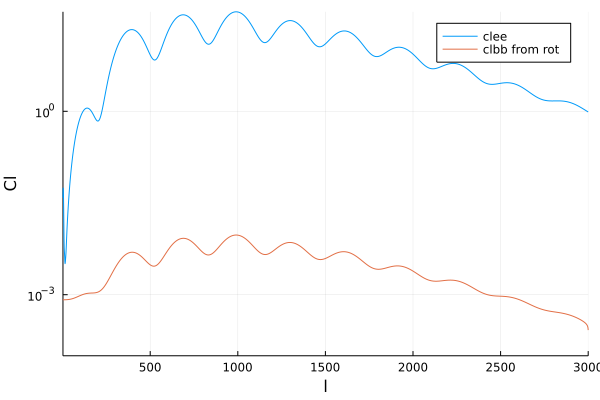

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/yilun/.julia/packages/Plots/9C6z9/src/utils.jl:95
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots /home/yilun/.julia/packages/Plots/9C6z9/src/utils.jl:95


In [16]:
plot(l, [clee clbb_rot], labels=["clee" "clbb from rot"], xlims=(2,3000), xlabel="l", ylabel="Cl", yaxis=:log, ylim=(1e-4,Inf))